Deformable convolution

<div dir="rtl">
<font face="B Nazanin" size="5">
سوالات تئوری :

الف) در کانولوشن عادی پنجره متحرک ما از نقاط ثابتی مقدار ورودی را بر می دارد و در وزن های خود ضرب می کند و در فرآیند آموزش مقدار وزن ها را آموزش می بیند
اما در کانولوشن قابل دیفورم مکان نقاط سمپل برداری پنجره در هر نقطه از ورودی نیز یاد گرفته می شوند
به این صورت که به اندازه سایز کرنل ، مقدار آفست برای هر نقطه پیش بینی می شود و پنجره مکانی که آفست به آن اشاره می کند را سمپل می کند
آفست عددی اعشاری است، به همین دلیل برای مقدار دهی به نقطه اشاره شده توسط آفست از روش  bilinear interpolation استفاده می شود

ب) شبکه های کانولوشنی عادی نسبت به تغییر سایز جسم و چرخش حساس هستند اما شبکه های کانولوشنی دیفورمیبل می توانند با آفست نقاط سمپل برداری را به طوری انتخاب کنند که چرخش و تغییر سایز را خنثی کنند ، علاوه بر آن به دلیل توانایی تغییر پنجره مربعی به هر شکل هندسی دلخواه توانایی در تشخیص اجسام مختلف افزایش می یابد.

ج) ماهیت شبکه کانولوشن در ابتدا این گونه بوده است که به صورتی اطلاعات را استخراج کند که به تغییر موقعیت اجسام حساس نباشد. برای همین یک پنجره متحرک در صفحه دارد، اما این قابلیت در آن پیش بینی نشده که چرخش و تغییر سایز را در نظر بگیرد . هر دو این اتفاق مکانی که پنجره از روی آن رد می شود و اعدادی که در آن قرار می گیرد را تغییر می دهند و طبیعی است که شبکه به خوبی اول خود کار نمیکند

د) آفست های داخل شبکه کانولوشن دیفورمیبل خود از یک کانولوشن بر روی ورودی به دست می آیند. خروجی این شبکه یک تنسور به سایز فضایی برابر با سایز ورودی و عمق دو برابر اندازه کرنل به توان دو است. یعنی دو مقدار ایکس و وای به ازای پنجره مربوط به هر پیکسل
</font>
</div>


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
import torchvision

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

we will use MNIST dataset

deformable convolution is particularly effective when the data is rotated or scaled

in order for the deformable convlution to show its effects we will do some data augmentation in the transform function

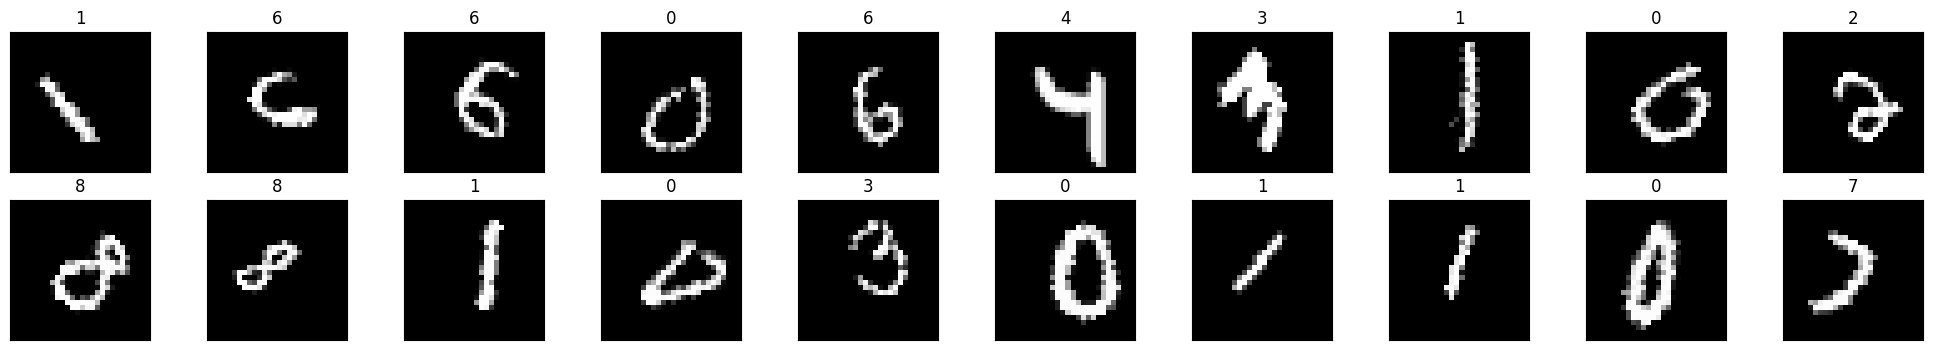

torch.Size([60000, 28, 28])


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.6, 1)),
    transforms.Normalize((0.1307,), (0.3081,))
])

mnist_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test_dataset, batch_size=64, shuffle=False)


dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)), cmap='gray')
    ax.set_title(str(labels[idx].item()))

plt.show()
print(mnist_train_dataset.data.shape)

first we will use a very basic convolution structure with one conv layer with relu activation and one maxpool layer

In [3]:
class reg_conv_model(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, dilation=1, bias=True):
        super(reg_conv_model, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = stride, padding = padding , dilation = dilation, bias = bias)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(196, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [4]:
# training loop
model = reg_conv_model(1, 1, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f'epoch {epoch}, loss {loss.item()}')

epoch 0, loss 1.635800838470459
epoch 1, loss 1.9861490726470947
epoch 2, loss 1.683726191520691
epoch 3, loss 1.7852516174316406
epoch 4, loss 1.7084999084472656
epoch 5, loss 1.6616020202636719
epoch 6, loss 1.6778477430343628
epoch 7, loss 1.3914309740066528
epoch 8, loss 1.464921236038208
epoch 9, loss 1.3676761388778687


In [5]:
# test
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print(f'accuracy {correct / total}')

accuracy 0.4414


as we can see , accuracy is not good because of the data augmentation

now we will implement the deformable convolution, how should we do it ?

manipulation of the torch Conv2D for deformable convolution seems unfesible so we have to think of another way.
the trick is to use the offset values to make a bigger matrix with size X_input * kernel_size and y_input * kernel_size and then use a regular convolution with stride = kernel_size to get the job done.
its like we are doing the sampling process manualy before hand and then use a regular convolution to get the output.
for sampling we use the grid_sample function in pytorch which gets a grid and an input and samples the input using the grid.
this fuction samples the input one element at a time, so we have to use it kernel_size*kernel_size times to get all the values needed for the convolution.


the exact process is as follows :

1. we pass the input through a regular conv layer to get the offset values

2. we use the offset values to sample the input using grid sampling, we do it kernel_size*kernel_size times to get all the values in the conv window

3. now we have kernel_size*kernel_size matrices each corresponding to a value in a specific location in the conv window for each input element, we interleave these matrices to get a big matrix with size X_input * kernel_size and y_input * kernel_size

4. we pass this big matrix through a regular conv layer with stride = kernel_size to get the output


then we use the same structure as above to test the deformable convolution performance

In [6]:
class def_conv_layer(nn.Module):
    def __init__(self, in_channels, out_channels, spatial_size, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(def_conv_layer, self).__init__()
        self.kernel_size = kernel_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride
        self.padding = padding

        self.offset_conv = nn.Conv2d(in_channels = in_channels, out_channels = 2 * kernel_size * kernel_size, kernel_size = 3, stride = 1, padding = 1, dilation = 1, bias = bias)
        self.grid_smaple = nn.functional.grid_sample
        self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = kernel_size, stride = kernel_size, padding = padding , dilation = dilation, bias = bias)

    def forward(self, x):
        offset = self.offset_conv(x)
        offset = torch.reshape(offset, (x.shape[0], x.shape[2], x.shape[3], self.kernel_size, self.kernel_size, 2))
        
        
        expand_matrices_list = []
        for i in range(self.kernel_size):
            for j in range(self.kernel_size):
                expand_matrices_list.append(self.grid_smaple(x, offset[:, :, :, i, j, :], mode='bilinear', padding_mode='zeros', align_corners=None))
        
        expanded_x = torch.zeros((x.shape[0], x.shape[1], x.shape[2]*self.kernel_size, x.shape[3]*self.kernel_size)).to(device)

        # interleaving the matrices in the list
        mat1 = torch.stack((expand_matrices_list[0], expand_matrices_list[1], expand_matrices_list[2]), dim = 3)
        mat1 = mat1.permute(0,1,2,4,3)
        mat1 = torch.flatten(mat1, start_dim=3, end_dim=4)
        mat2 = torch.stack((expand_matrices_list[3], expand_matrices_list[4], expand_matrices_list[5]), dim = 3)
        mat2 = mat2.permute(0,1,2,4,3)
        mat2 = torch.flatten(mat2, start_dim=3, end_dim=4)
        mat3 = torch.stack((expand_matrices_list[6], expand_matrices_list[7], expand_matrices_list[8]), dim = 3)
        mat3 = mat3.permute(0,1,2,4,3)
        mat3 = torch.flatten(mat3, start_dim=3, end_dim=4)

        expanded_x = torch.stack((mat1, mat2, mat3), dim = 2)
        expanded_x = expanded_x.permute(0,1,3,2,4)
        expanded_x = torch.flatten(expanded_x, start_dim=2, end_dim=3)
        
        # check if the two methods are the same
        
        out = self.conv(expanded_x)
        return out
    


# now we use the same structure as before but with the new conv layer
class def_conv_model(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
        super(def_conv_model, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        self.conv = def_conv_layer(in_channels, 1, (28, 28), kernel_size, stride, padding, dilation, bias)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(196, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x
        

In [7]:
# training loop
model = def_conv_model(1, 1, 3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

for epoch in range(10):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'epoch {epoch}, loss {loss.item()}')

c:\Users\lesol\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


epoch 0, loss 1.5163733959197998
epoch 1, loss 1.8861477375030518
epoch 2, loss 1.4583137035369873
epoch 3, loss 1.5518393516540527
epoch 4, loss 1.4515018463134766
epoch 5, loss 1.2525076866149902
epoch 6, loss 1.492597222328186
epoch 7, loss 1.478524088859558
epoch 8, loss 1.5587639808654785
epoch 9, loss 1.601120114326477


In [8]:
# test
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
    print(f'accuracy {correct / total}')

accuracy 0.5071


<div dir="rtl">
<font face="B Nazanin" size="5">
مشاهده می شود کانولوشن دیفورمیبل بهتر عمل کرده است. با توجه به دیتاست ساده و سبک mnist این تفاوت به خوبی مشخص نیست اما در دیتاست های بزرگتر و پیچیده تفاوت بیشتری مشخص خواهد بود
</font>
</div>